In [ ]:
pip install visualkeras

In [668]:
# Import libraries
import sys, glob, os
import numpy as np
import scipy as sp
import pandas as pd
from csv import reader, writer
import joblib
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Activation, Input, Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, Reshape, LeakyReLU
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import visualkeras

In [209]:
# Activiate GPU
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [210]:
# current working directory
cwd = '/content/drive/MyDrive/Daylight Autonomy/'

# Data setup

In [368]:
# load data from data folder
files = glob.glob(os.path.join(cwd, "data", "*.txt"))
dfs = [pd.read_csv(f, header=None, sep=";") for f in files]

df = pd.concat(dfs,ignore_index=True)

In [372]:
# Clean data
headers = list(df.iloc[0,0:9])

data = df.iloc[:,10:18].copy()
data.columns = headers[0:8]

target = df.iloc[:,-930:].copy()
target.columns = range(len(target.columns))
target = np.array(target).reshape(len(df),30,31)

In [374]:
# Split data to train, validate, test set (60% training, 20% validation, 20% test split)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=98)

##### backup hyperparameters

In [ ]:
# Space for hyperparameters of previous runs

"""
model.add(Conv2DTranspose(filters=128, kernel_size=4,strides=(2,1)))
model.add(Conv2DTranspose(filters=64, kernel_size=2,strides=(2,2)))
model.add(Conv2DTranspose(filters=32, kernel_size=(3,2),strides=(1,1)))
model.add(Conv2DTranspose(filters=16, kernel_size=3,strides=(2,1)))
model.add(Conv2DTranspose(filters=8, kernel_size=4,strides=(1,1)))
model.add(Conv2DTranspose(filters=4, kernel_size=(7,4),strides=(1,1)))
model.add(Conv2DTranspose(filters=1, kernel_size=1, padding="same"))
"""

"""
model.add(Conv2DTranspose(filters=128, kernel_size=(2,2), strides=(2,1)))
model.add(Conv2DTranspose(filters=64, kernel_size=(3,2), strides=(2,1)))
model.add(Conv2DTranspose(filters=32, kernel_size=(2,2), strides=(2,1)))
model.add(Conv2DTranspose(filters=16, kernel_size=12, strides=(1,1)))
model.add(Conv2DTranspose(filters=4, kernel_size=6, strides=(1,1)))
model.add(Conv2DTranspose(filters=2, kernel_size=5, strides=(1,1)))
model.add(Conv2DTranspose(filters=1, kernel_size=1, padding="same"))

"""

"""
model.add(Conv2DTranspose(filters=64, kernel_size=4,strides=(2,1)))
model.add(Dropout(rate=0.2))
model.add(Conv2DTranspose(filters=32, kernel_size=4,strides=(2,1)))
model.add(Dropout(rate=0.2))
model.add(Conv2DTranspose(filters=32, kernel_size=4,strides=(1,1)))
model.add(Dropout(rate=0.2))
model.add(Conv2DTranspose(filters=32, kernel_size=4,strides=(1,1)))
model.add(Dropout(rate=0.2))
model.add(Conv2DTranspose(filters=32, kernel_size=5,strides=(1,1)))
model.add(Dropout(rate=0.2))
model.add(Conv2DTranspose(filters=32, kernel_size=(7,6),strides=(1,1)))
model.add(Dropout(rate=0.2))
model.add(Conv2DTranspose(filters=32, kernel_size=(5,3),strides=(1,1)))
model.add(Dropout(rate=0.2))
model.add(Conv2DTranspose(filters=1, kernel_size=1, padding="same"))
"""

"""
model.add(Dense(32 * 1 * 8, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001), input_dim=8))
model.add(Activation('selu'))

model.add(Dense(64 * 1 * 8, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('selu'))

model.add(Dense(128 * 1 * 8, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('selu'))
"""

"""
model.add(Dense(32 * 1 * 8, input_dim=8, activation='relu'))

model.add(Dense(64 * 1 * 8, activation='relu'))

model.add(Dense(128 * 1 * 8, activation='relu'))
"""

# Model and training

In [815]:
# Clear keras workspace for new model
keras.backend.clear_session()

# Deconvolutional Neural Network Model (DCNN) for generating daylight autonomy
model = Sequential()

### DNN model to analysis the input parameters
model.add(Dense(32 * 1 * 8, input_dim=8, activation='relu'))

model.add(Dense(64 * 1 * 8, activation='relu'))

model.add(Dense(128 * 1 * 8, activation='relu'))

### Deconvolution to generate image
model.add(Reshape((1, 8, 128)))

model.add(Conv2DTranspose(filters=128, kernel_size=(2,2), strides=(2,1)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Conv2DTranspose(filters=64, kernel_size=(3,2), strides=(2,1)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Conv2DTranspose(filters=32, kernel_size=(2,2), strides=(2,1)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Conv2DTranspose(filters=16, kernel_size=6, strides=(1,1)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Conv2DTranspose(filters=16, kernel_size=6, strides=(1,1)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Conv2DTranspose(filters=4, kernel_size=6, strides=(1,1)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Conv2DTranspose(filters=2, kernel_size=6, strides=(1,1)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Conv2DTranspose(filters=1, kernel_size=1, padding="same"))

# optimizer
model.compile(optimizer=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), loss="mse")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2304      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
reshape (Reshape)            (None, 1, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 2, 9, 128)         65664     
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 9, 128)         512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2, 9, 128)         0

In [816]:
history = model.fit(
    X_train,
    y_train,
    epochs = 1500,
    batch_size = 8,
    validation_data = (X_val, y_val),
    callbacks = [
                 EarlyStopping(monitor='val_loss', patience=150, mode='min'),
                 ModelCheckpoint(filepath = 'CNN2D.ckpt', save_weights_only=True, monitor='val_loss', save_best_only=True)
    ]
)

Epoch 1/1500
50/50 [==============================] - 2s 17ms/step - loss: 441.7782 - val_loss: 430.3992
Epoch 2/1500
50/50 [==============================] - 0s 9ms/step - loss: 427.0959 - val_loss: 367.2675
Epoch 3/1500
50/50 [==============================] - 0s 10ms/step - loss: 417.9011 - val_loss: 344.7588
Epoch 4/1500
50/50 [==============================] - 0s 9ms/step - loss: 407.5144 - val_loss: 359.0717
Epoch 5/1500
50/50 [==============================] - 1s 10ms/step - loss: 397.6671 - val_loss: 357.6804
Epoch 6/1500
50/50 [==============================] - 0s 9ms/step - loss: 385.3268 - val_loss: 320.2432
Epoch 7/1500
50/50 [==============================] - 0s 9ms/step - loss: 373.9948 - val_loss: 284.4535
Epoch 8/1500
50/50 [==============================] - 0s 9ms/step - loss: 363.8618 - val_loss: 327.8226
Epoch 9/1500
50/50 [==============================] - 0s 9ms/step - loss: 349.5093 - val_loss: 321.1787
Epoch 10/1500
50/50 [==============================] - 0s 8ms

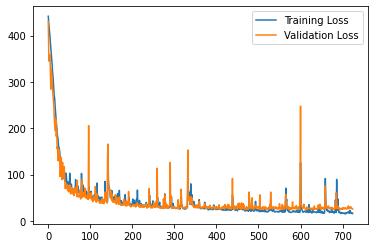

In [817]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [820]:
model.load_weights('CNN2D.ckpt');

In [821]:
y_pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test.reshape(-1, 30 * 31), y_pred.reshape(-1, 30 * 31)))

5.25568087237129

In [834]:
k = 71

In [835]:
X_test.iloc[k]

SideA             4.798900
SideB            10.000000
SideC             4.798900
SideD            10.000000
WindowWidth       2.879340
WindowLength      1.250000
Orientation     315.000000
Area             45.857864
Name: 401, dtype: float64

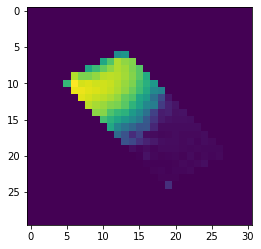

In [836]:
plt.imshow(y_test[k])

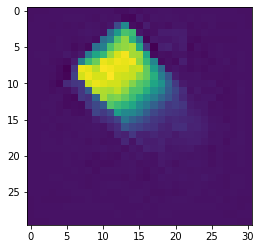

In [837]:
plt.imshow(y_pred[k].reshape(30,-1))

In [826]:
np.sqrt(mean_squared_error(y_test[k],y_pred[k].reshape(30,-1)))

1.4751205349226106

In [827]:
results = [np.sqrt(mean_squared_error(y_test[k],y_pred[k].reshape(30,-1))) for k in range(len(y_test))]    

In [828]:
# best result
results.index(min(results))

101

In [829]:
# worst result
results.index(max(results))

71

# Save model

In [739]:
json = os.path.join(cwd, 'models/DA_CNN.json')
hdf5 = os.path.join(cwd, 'models/DA_CNN.h5')

model_json = model.to_json()
with open(json,'w') as json_file:
    json_file.write(model_json)
model.save_weights(hdf5)

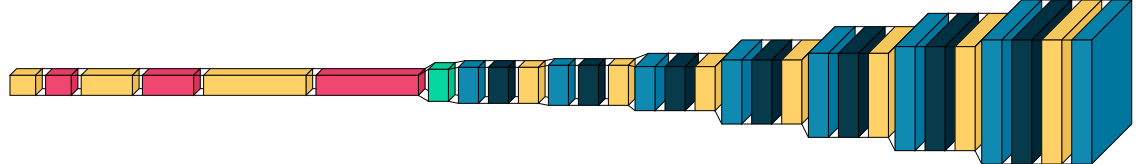

In [777]:
visualkeras.layered_view(model)

# Test for random input

In [790]:
test_case = np.array([4.7,8,6,9.52,2.87,1.25,45,45])

test_pred = model.predict(np.expand_dims(test_case, axis=0))[0].reshape(1,-1)

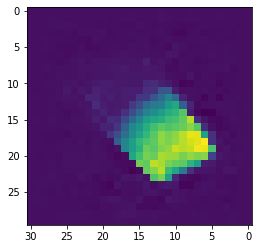

In [797]:
plt.imshow(test_pred.reshape(30,-1))
plt.gca().invert_xaxis()